# Ensemble Learning and Random Forests


 A group of predictors is called an **ensemble**; thus, this technique is called **Ensemble Learning**, and an **Ensemble Learning algorithm is called an Ensemble method**.

For example, you can train a group of Decision Tree classifiers, each on a different random subset of the training set.

To make predictions,
+ You just obtain the predictions of all individual trees,
+ then predict the class that gets the most votes.

**Such an ensemble of Decision Trees is called a Random Forest**, and despite its simplicity, this is one of the most powerful Machine Learning algorithms available today.



## Voting Classifiers

![Training diverse classifiers](images/ensembles/training_diverse_classifiers.png)

A very simple way to create an even better classifier is to aggregate the predictions of each classifier and predict the class that gets the most votes.
**This majority-vote classifier is called a hard voting classifier**.

![Hard voting classifier classification](images/ensembles/hard_voting.png)


Somewhat surprisingly, this voting classifier often achieves a higher accuracy than the best classifier in the ensemble.
+ In fact, even if each classifier is a weak learner (meaning it does only slightly better than random guessing), the ensemble can still be a strong learner (achieving high accuracy),
+ provided there are a sufficient number of weak learners and they are sufficiently diverse.

Let's train a voting classifier and check if it performs better than the individual classifiers

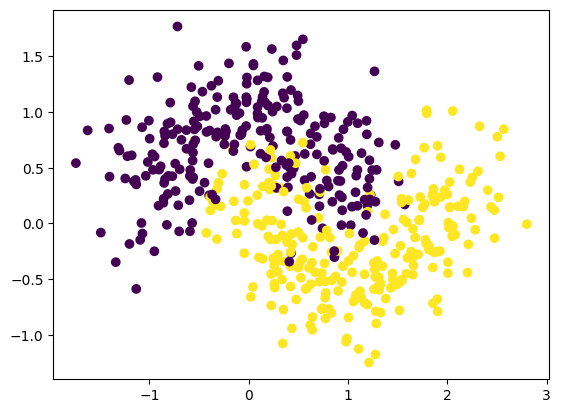

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

plt.scatter(X[:,0], X[:, 1], c=y)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [ ]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


**The voting classifier slightly outperforms all the individual classifiers.**


## Hard voting and Soft voting

+ If all classifiers are able to **estimate class probabilities (i.e., they have a predict_proba() method)**, then you can tell Scikit-Learn **to predict the class with the highest class probability, averaged over all the individual classifiers. This is called soft voting.**

+ It often achieves higher performance than hard voting because it gives more weight to highly confident votes. All you need to do is replace voting="hard" with voting="soft" and ensure that all classifiers can estimate class probabilities.

+ This is not the case of the SVC class by default, so you need to set its probability hyperparameter to True (this will make the SVC class use cross-validation to estimate class probabilities, slowing down training, and it will add a predict_proba() method).

Let us modify the preceding code to use soft voting, you will find that the voting classifier achieves over 91% accuracy!

In [ ]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [ ]:
for (name, prd) in ('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf):
    prd.fit(X_train, y_train)

In [ ]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## Bagging and Pasting


+ Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set.


+ When sampling **is performed with replacement, this method is called bagging (short for bootstrap aggregating2)**.
+ When sampling **is performed without replacement, it is called pasting**.


In other words, both bagging and pasting allow training instances to be sampled several times across multiple predictors, but only bagging allows training instances to be sampled several times for the same predictor

###**Pasting and Bagging**

+ The Pasting Ensemble is an extension to bagging that involves fitting ensemble members based on random samples of the training dataset instead of bootstrap samples.
+ Once all predictors are trained, the ensemble can make a prediction for a new instance by simply aggregating the predictions of all predictors.
+ The aggregation function is typically the statistical mode (i.e., the most frequent prediction, just like a hard voting classifier) for classification, or the average for regression.



Each individual predictor has a higher bias than if it were trained on the original training set, but aggregation reduces both bias and variance. Generally, the net result is that the ensemble has a similar bias but a lower variance than a single predictor trained on the original training set.




##**Dataset- The following code trains an ensemble of 500 Decision Tree classifiers, each trained on 100 training instances randomly sampled**




**1. The number of trees can be set via the “n_estimators” argument and defaults to 100.**
2. the number of trees is increased until the model performance stabilizes.

3. the training set with replacement (this is an example of bagging, but if you want to use pasting instead, just set bootstrap=False).

4. The number of samples used to fit each decision tree is set via the “max_samples” argument.


The n_jobs parameter tells Scikit-Learn the **number of CPU cores to use for training and predictions (–1 tells Scikit-Learn to use all available cores)**:

In [ ]:
## Example of Pasting. Notice the results.
## If it is possible to do pasting, it would, else, it would start repeating
## Pasting is possible if max_samples * n_estimators <= X = 0.2 * 10 = 2
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
X_train1 = np.array([[1, 1],[1, 0], [0, 1], [0,0], [0,0], [0,0]])
y_train1 = np.array([0, 1, 1, 0, 0, 0])
bag_clf1 = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=10,
    max_samples=0.2,
    bootstrap=True,
    n_jobs=-1,
    random_state=42
)

bag_clf1.fit(X_train1, y_train1)
#bag_clf1.estimators_samples_

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=0.2,
                  n_jobs=-1, random_state=42)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf1.predict(X_test)
accuracy_score(y_pred, y_test)
print(accuracy_score(y_test, y_pred))

0.488


In [ ]:
## bagging ensemble method
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    max_samples=300,
    bootstrap=True,
    n_jobs=-1
)

bag_clf.fit(X_train, y_train)


BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=300,
                  n_estimators=500, n_jobs=-1)

In [ ]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.904

###**hypertuning parameters for bagging classifier model**

In [ ]:
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=4,n_informative=2, n_redundant=0,random_state=0, shuffle=False)
clf = BaggingClassifier(estimator=SVC(),n_estimators=10, random_state=0).fit(X, y)
clf.predict([[1, 1, 0, 1]])

array([1])

##whereas for the individual tree we have

In [ ]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


##Let's visualize how the Bagging classifier generalizes well on the data

In [ ]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

<ipython-input-13-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-13-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)


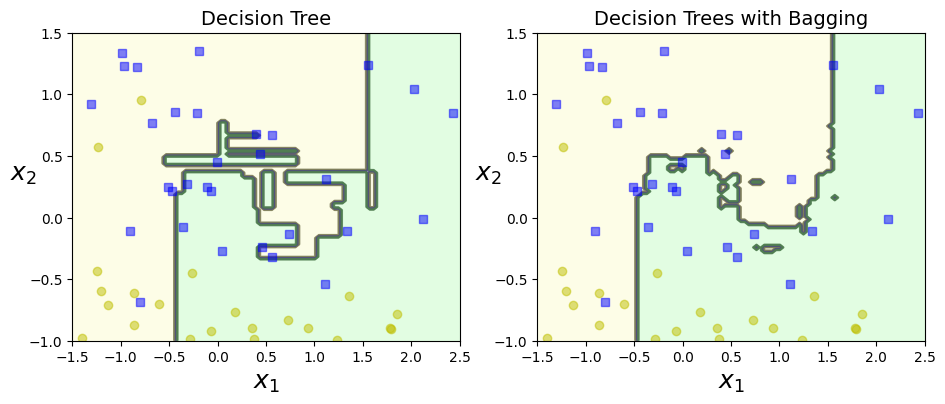

In [ ]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)

plt.show()

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced.

Overall, bagging often results in better models, which explains why it is generally preferred.

## Out of Bag Evaluation


 **once a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.
In Scikit-Learn, you can set oob_score=True when creating a BaggingClassifier to request an
automatic oob evaluation after training.**

The following code demonstrates this. The resulting evaluation score is available through the **oob\_score\_** variable:

**The bagging technique can also be used to combine the predictions of other types of models.**
1. bootstrap aggregation is based on the idea of the “bootstrap” sample.
2. A bootstrap sample is a sample of a dataset with replacement. Replacement means that a sample drawn from the dataset is replaced, allowing it to be selected again and perhaps multiple times in the new sample. This means that the sample may have duplicate examples from the original dataset.


In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(),
    n_estimators=500,
    bootstrap=True,
    random_state=42,
    n_jobs=-1,
    oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

In [ ]:
bag_clf

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=500,
                  n_jobs=-1, oob_score=True, random_state=42)

In [ ]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

In [ ]:
# Get the indices of OOB samples
oob_indices = bag_clf.oob_decision_function_.argmax(axis=1)

In [ ]:
print("Indices of OOB samples:", oob_indices)

Indices of OOB samples: [1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1
 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 0 0 1 0 0
 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1
 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0
 0 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0
 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1
 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0
 1 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0
 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1
 1 0 0 1 0]


## Random Forests

###The Random Forest algorithm introduces extra randomness when growing trees;
+ A Random Subspace Ensemble is an extension to bagging that involves fitting ensemble members based on datasets constructed from random subsets of the features in the training dataset.
+ instead of searching for the very best feature when splitting a node. use Random function for it.
+The classifier consists of multiple trees constructed systematically by pseudorandomly selecting subsets of components of the feature vector, that is, trees constructed in randomly chosen subspaces.
+ The Random Patches Ensemble is an extension to bagging that involves fitting ensemble members based on datasets constructed from random subsets of rows (samples) and columns (features) of the training dataset.
+ It does not use bootstrap samples and might be considered an ensemble that combines both the random sampling of the dataset of the Pasting ensemble and the random sampling of features of the Random Subspace ensemble.

In [ ]:
## train data using Bagging classifier for randomly subset
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [ ]:
## find out the accuracy using the Bagging classifier.
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

### use Randomforestclassifier
Random Forests build multiple decision trees over bootstrapped subsets of the data, whereas Extra Trees algorithms build multiple decision trees over the entire dataset.

In [ ]:
## train the data using Randomforestclassifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, oob_score=True, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [ ]:
## predict the accuracy
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred_rf)

0.912

##The **oob_score** attribute allows you to obtain an out-of-bag (OOB) score, which is an estimate of the classifier's performance on unseen data without the need for cross-validation or a separate test set.

In [ ]:
rnd_clf.oob_score_

0.9173333333333333

In [ ]:
rnd_clf.oob_score

True

In [ ]:
# Get the indices of OOB samples
oob_indices = rnd_clf.oob_decision_function_.argmax(axis=1)

In [ ]:
print("Indices of OOB samples:", oob_indices)

Indices of OOB samples: [1 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 0 0 1 0 1 0 1 1 1 0 1
 1 1 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 0 0 0 1 0 0 0 0 0 1 1 0 0
 1 1 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 1 1 0 1
 0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 0 1 0 1 1 0 0 0 0 0 1 0 1 1 1 0 0
 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 0 1 0 0 1 0 0 0 1 1 0
 1 0 1 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 1 1 0 1 1 0 0 0 1
 1 0 1 1 1 0 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0
 1 0 1 1 0 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0 1 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0
 1 1 0 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 0 1 1 0 0 0 1 0 1 0
 1 0 0 0 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 0 0 1 0 1
 1 0 0 1 0]


### The **feature_importances_** attribute allows you to access the importance scores of each feature used by the random forest to make predictions. These scores indicate how much each feature contributes to the model's decision-making process.

In [ ]:
rnd_clf.feature_importances_

array([0.42253629, 0.57746371])

### Feature Importances USING RANDOM FOREST CLASSIFIER ON IRIS dataset



Feature Importances:
petal length (cm): 0.4361295069034437
petal width (cm): 0.43606478004168353
sepal length (cm): 0.10612761987750428
sepal width (cm): 0.02167809317736852


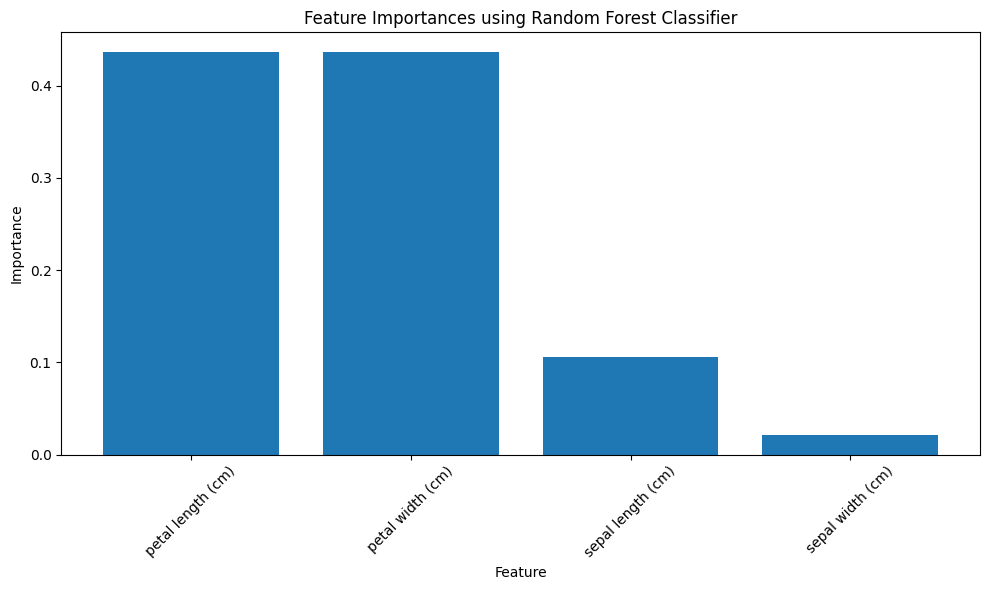

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Load the Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the data
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_

# Sort indices based on feature importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Print feature importance scores and names
print("Feature Importances:")
for i in sorted_indices:
    print(f"{iris.feature_names[i]}: {feature_importances[i]}")

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(X.shape[1]), feature_importances[sorted_indices], tick_label=np.array(iris.feature_names)[sorted_indices])
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Feature Importances using Random Forest Classifier")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## get feature importance visualisation  on MNIST Dataset


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


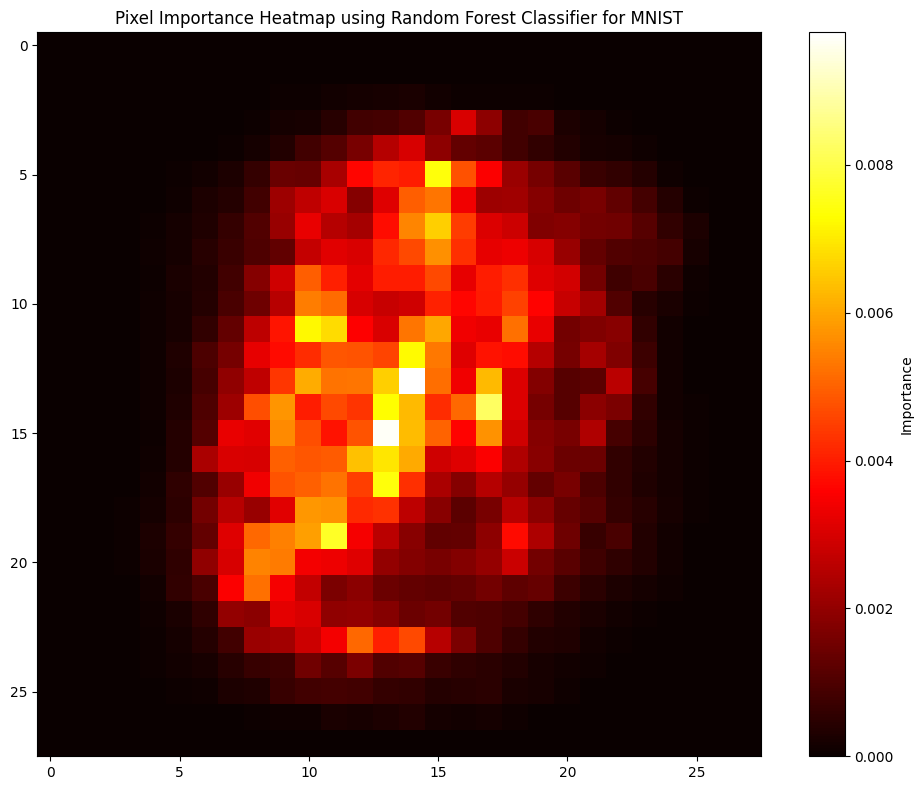

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier

# Load the MNIST dataset
mnist = fetch_openml("mnist_784")
X = mnist.data
y = mnist.target.astype(int)

# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the data
rf_classifier.fit(X, y)

# Get feature importances
feature_importances = rf_classifier.feature_importances_.reshape(28, 28)

# Plotting the feature importances heatmap with a colorbar
plt.figure(figsize=(10, 8))
plt.imshow(feature_importances, cmap='hot', interpolation='nearest')
plt.colorbar(label='Importance')
plt.title("Pixel Importance Heatmap using Random Forest Classifier for MNIST")
plt.tight_layout()
plt.show()


# **ExtraTree classifier**

### The **Extra Trees** When you are growing a tree in a Random Forest, at each node only a random subset of the features is considered for splitting. It is possible to make trees even more random by also using random thresholds for each feature rather than searching for the best possible thresholds (like regular Decision Trees do)

In [ ]:
## train the model using extratree classifier
from sklearn.ensemble import ExtraTreesClassifier

extra_tree_clf = ExtraTreesClassifier(n_estimators=195, max_leaf_nodes=16, n_jobs=-1, random_state=42)
extra_tree_clf.fit(X_train, y_train)


ExtraTreesClassifier(max_leaf_nodes=16, n_estimators=195, n_jobs=-1,
                     random_state=42)

In [ ]:
y_pred_extra_trees = extra_tree_clf.predict(X_test)
accuracy_score(y_pred_extra_trees, y_pred)

0.992

## **AdaBoost**

##One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focusing more and more on the hard cases. This is the technique used by Ada-Boost.


In [ ]:
## train the model using ADABoost
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=150,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)


AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=150, random_state=42)

In [ ]:
## predict the accuracy
y_pred_ada_clf = ada_clf.predict(X_test)
accuracy_score(y_test, y_pred_ada_clf)

0.904

In [ ]:
## plot decision boundry
y_pred_ada_clf = ada_clf.predict(X_test)


<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)


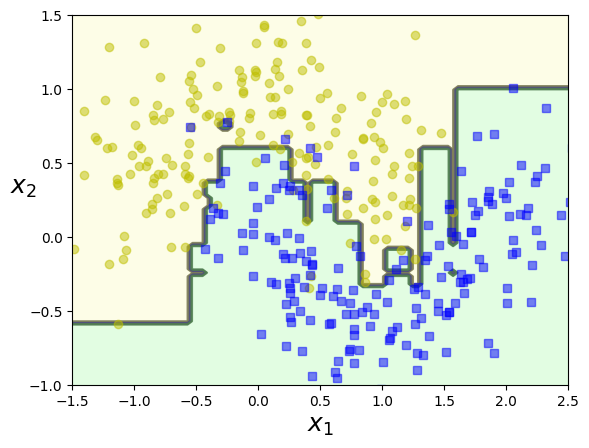

In [ ]:
plot_decision_boundary(ada_clf, X_train, y_train)

Change the learning rate

<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by contour: 'linewidth'
  plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
<ipython-input-10-8becff8bfc49>:11: UserWarning: The following kwargs were not used by con

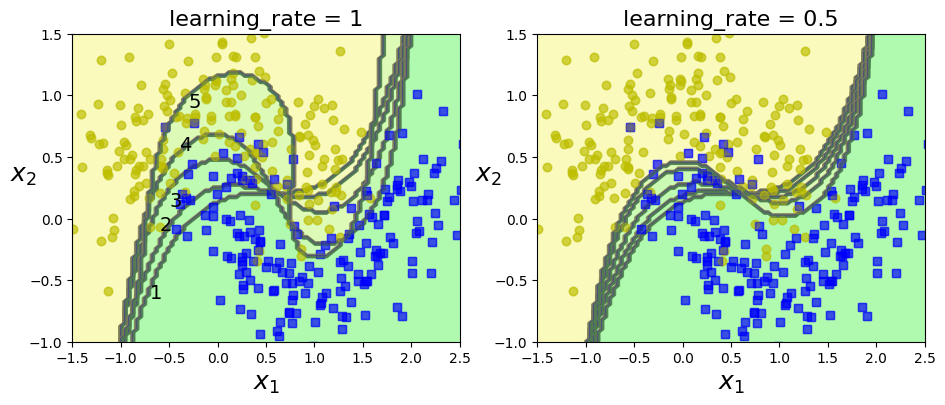

In [ ]:
from sklearn.svm import SVC
m = len(X_train)
plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        plot_decision_boundary(svm_clf, X_train, y_train, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)

plt.show()

## take data

In [ ]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [ ]:
# train the data using decisionTreeclassifier
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

In [ ]:
X_new = np.array([[0.3]])
X_new

array([[0.3]])

In [ ]:
y_pred_array = [tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3)]
y_pred = sum(y_pred_array)
y_pred

array([0.17052257])

In [ ]:
y_pred_array

[array([0.12356613]), array([0.03991297]), array([0.00704347])]

In [ ]:
y_pred

array([0.17052257])

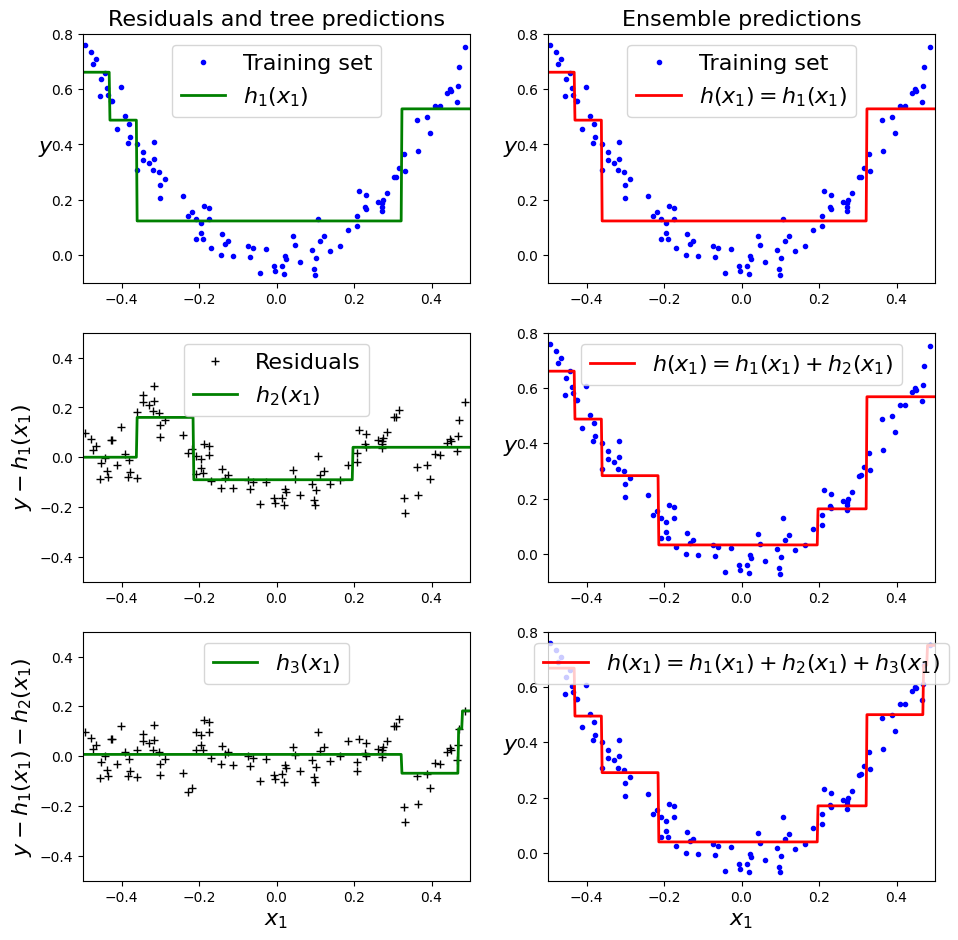

In [ ]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)


plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
gbrt.predict([[0.2]])

array([0.17052257])

In [ ]:

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=29, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)
y_pred = gbrt_slow.predict(X)
gbrt_slow.loss_(y, y_pred) #MSE

/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


0.0021618964019748618

In [ ]:
np.sum(np.square([y - y_pred])) / len(y)

0.0021618964019748618

In [ ]:
gbrt_slow.predict([[0.2]])

array([0.11642022])

In [ ]:
for i, y_pred in enumerate(gbrt_slow.staged_predict(X)):
    x = gbrt_slow.loss_(y, y_pred)
    print(x)
    if x < 0.00216189640197:
        break;
    print(i)

0.04764465381991766
0
0.0403629889655186
1
0.03436807660288836
2
0.02940401879121217
3
0.02566408261649072
4
0.022030359115393198
5
0.019116061552538505
6
0.016534140874705915
7
0.014384068982595689
8
0.012583552023704479
9
0.011129489512017136
10
0.00997541340545445
11
0.00882675253304006
12
0.007933890138589328
13
0.007196407291525276
14
0.006563781847832413
15
0.006022596579032788
16
0.005403487547077464
17
0.004935743997108108
18
0.004480216393382758
19
0.0041511141327776405
20
0.0037661420830949273
21
0.0035033686563123185
22
0.003216775966133666
23
0.002904652648127405
24
0.002735944574608821
25
0.002593108629122235
26
0.002378188885128215
27
0.0021618964019748618
28


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


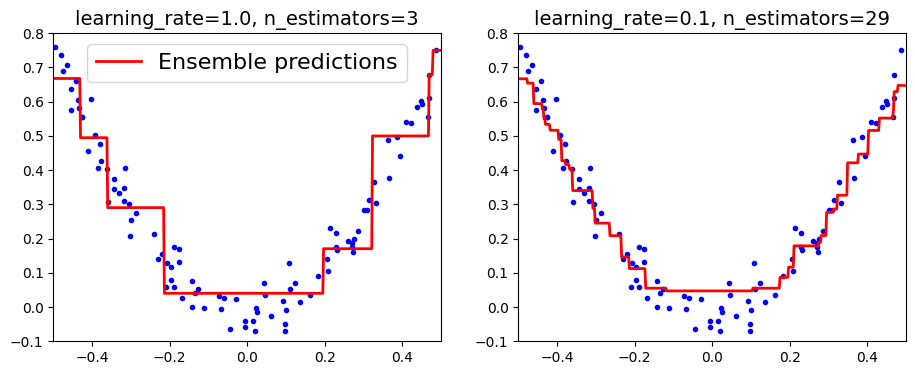

In [ ]:

plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

## early stopping

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=20, learning_rate=0.1, random_state=42, warm_start=True)

gbrt_slow.fit(X, y)
y_pred = gbrt_slow.predict(X)
print(gbrt_slow.loss_(y, y_pred))

gbrt_slow.fit(X, y)
y_pred = gbrt_slow.predict(X)

print(gbrt_slow.loss_(y, y_pred))

0.004480216393382758
0.004480216393382758


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `loss_` was deprecated in version 1.1 and will be removed in 1.3.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from sklearn.metrics import mean_squared_error

gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)
min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    print(n_estimators)
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_test)
    val_error = mean_squared_error(y_test, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            print("Stopping")
            break # early stopping

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
Stopping


### Gradient Boosting with early stopping



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=55, random_state=42)

In [ ]:
min_error = np.min(errors)


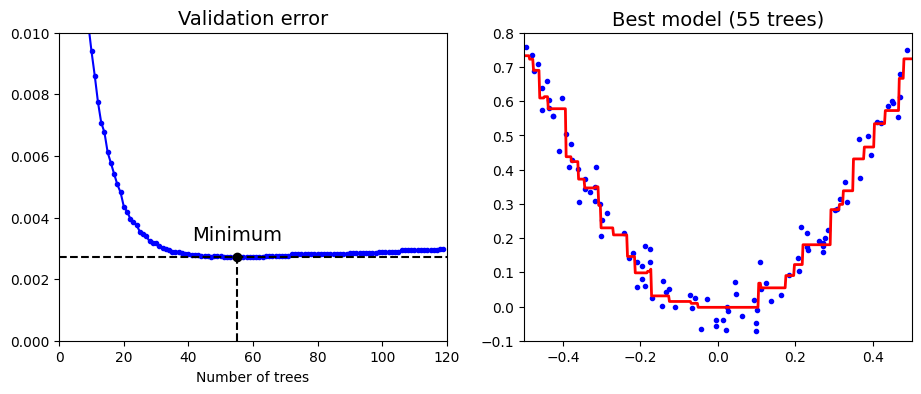

In [ ]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)


plt.show()

## XGBoost

In [ ]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = mnist.data.astype('float32') / 255.0  # Normalize pixel values
y = mnist.target.astype('int')

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [ ]:
# Create an XGBoost classifier
xgb_clf = XGBClassifier(
    objective='multi:softmax',  # For multiclass classification
    num_class=10,  # Number of classes (digits in this case)
    n_estimators=100,  # Number of boosting rounds
    max_depth=3,  # Maximum depth of individual trees
    learning_rate=0.1,  # Step size shrinkage
    random_state=42
)

# Train the XGBoost classifier
xgb_clf.fit(X_train, y_train)



XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_class=10,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [ ]:
from sklearn.metrics import accuracy_score

# Predict labels on test data
y_pred = xgb_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9340714285714286


**Hyperparameter tuning**

In [ ]:

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# Create an instance of the XGBClassifier
xgb_classifier = XGBClassifier(random_state=42)

# Define the parameter grid for Random Search
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3],
    'gamma': [0, 0.1, 0.2]
}

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(xgb_classifier, param_distributions=param_dist,
                                   n_iter=10, scoring='accuracy', cv=3, verbose=1,
                                   random_state=42, n_jobs=-1)

# Fit the random search to the data
random_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
best_params = random_search.best_params_
best_estimator = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [ ]:
# Predict on the testing data using the best estimator
y_pred = best_estimator.predict(X_test)

# Evaluate the classifier's performance
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)


### Stacking

In [ ]:
# Create Dataset
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, random_state=42)


In [ ]:
# Train
log_clf_s = LogisticRegression(random_state=42)
rnd_clf_s = RandomForestClassifier(random_state=42)
svm_clf_s = SVC(random_state=42, probability=True)

rnd_clf_2 = RandomForestClassifier(random_state=42)

for p in [log_clf_s, rnd_clf_s, svm_clf_s]:
    p.fit(X_train_1, y_train_1)

log_clf_p = log_clf_s.predict(X_train_2)
rnd_clf_p = rnd_clf_s.predict(X_train_2)
svm_clf_p = svm_clf_s.predict(X_train_2)

held_out = np.column_stack((log_clf_p, rnd_clf_p, svm_clf_p))
rnd_clf_2.fit(held_out, y_train_2)

In [ ]:
# Predict

result_1 = []
for p in [log_clf_s, rnd_clf_s, svm_clf_s]:
    result_1.append(p.predict(X_test))

y_pred_s = rnd_clf_2.predict(np.column_stack(tuple(result_1)))
accuracy_score(y_test, y_pred_s)